<h1><center><b>Hawkes Model for Price and Trades High-Frequency Dynamics</b></center></h1>

Hugo Fourel, Loïc Imbert, Valentin Vidril

Link towards GitHub repository: https://github.com/lilhugo/Hawkes-Process-ATCourse

Our numerical implementation was threefold:
- First, we implemented a thinning algoritm in order to simulate the Hawkes processes of the article,
- Then, we computes the autocovariances,
- We then tries to estimate the kernel parameters.

# Hawkes Process Simulation

In [1]:
import os
import mpmath as mp
from mpmath import invertlaplace
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import copy
import scipy
import pandas as pd
from Generator import PointProcess

mp.mp.dps = 10
mp.mp.pretty = True

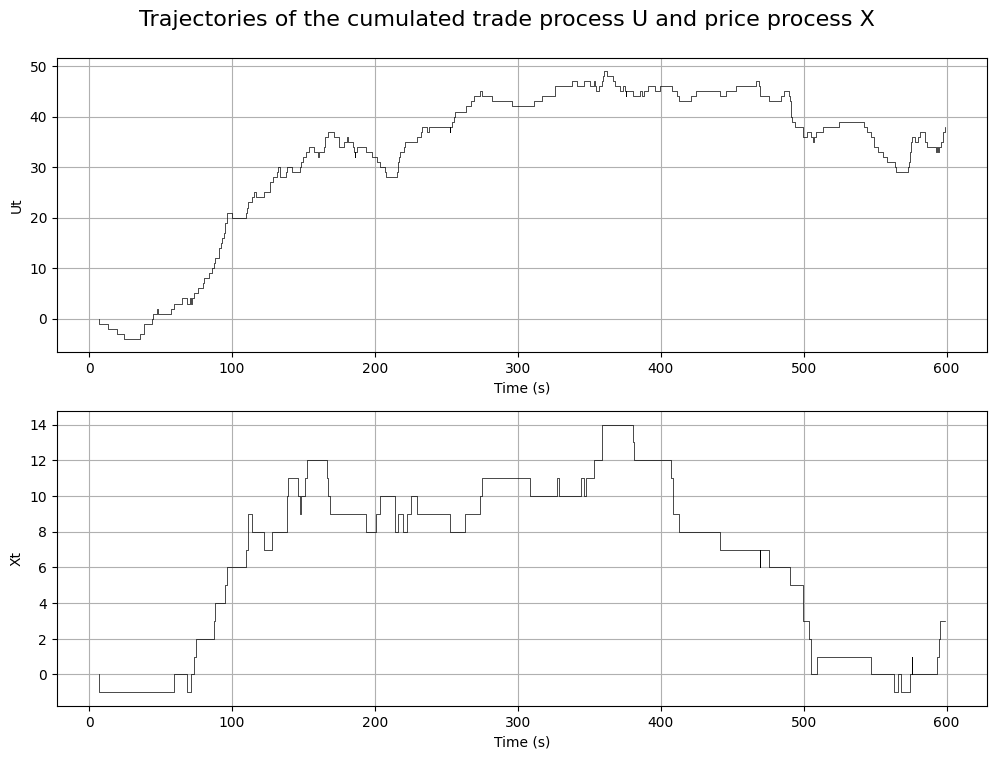

In [2]:
# Simulating trajectories of the cumulated trade process U and price process X

pointprocess_short = PointProcess(.1, 600)
pointprocess_short.simulate()
pointprocess_short.plot()

# Autocovariance

In [4]:
# Parameters and functions to invert the Laplace transform

mu = 0.1
h = 1

alpha_Ts = 0.03
alpha_Tc = 0.0
alpha_Ns = 0.0
alpha_Nc = 0.05
alpha_Is = 25.0
alpha_Ic = 0.0
alpha_Fs = 0.0
alpha_Fc = 0.1

beta_Ts = 0.05
beta_Tc = 0.0
beta_Ns = 0.0
beta_Nc = 0.1
beta_Is = 100.0
beta_Ic = 0.0
beta_Fs = 0.0
beta_Fc = 0.5

def __phiTs(t) -> float:
    return alpha_Ts * mp.exp(-beta_Ts * t)

def __phiTc(t) -> float:
    return alpha_Tc * mp.exp(-beta_Tc * t)

def __phiNs(t) -> float:
    return alpha_Ns * mp.exp(-beta_Ns * t)

def __phiNc(t) -> float:
    return alpha_Nc * mp.exp(-beta_Nc * t)

def __phiIs(t) -> float:
    return alpha_Is * mp.exp(-beta_Is * t)     

def __phiIc(t) -> float:
    return alpha_Ic * mp.exp(-beta_Ic * t)

def __phiFs(t) -> float:
    return alpha_Fs * mp.exp(-beta_Fs * t)

def __phiFc(t) -> float:
    return alpha_Fc * mp.exp(-beta_Fc * t)

def __hatPhiTs(z) -> float:
    return alpha_Ts / (z + beta_Ts) if alpha_Ts != 0 else 0

def __hatPhiTc(z) -> float:
    return alpha_Tc / (z + beta_Tc) if alpha_Tc != 0 else 0

def __hatPhiNs(z) -> float:
    return alpha_Ns / (z + beta_Ns) if alpha_Ns != 0 else 0

def __hatPhiNc(z) -> float:
    return alpha_Nc / (z + beta_Nc) if alpha_Nc != 0 else 0

def __hatPhiIs(z) -> float:
    return alpha_Is / (z + beta_Is) if alpha_Is != 0 else 0 

def __hatPhiIc(z) -> float:
    return alpha_Ic / (z + beta_Ic) if alpha_Ic != 0 else 0

def __hatPhiFs(z) -> float:
    return alpha_Fs / (z + beta_Fs) if alpha_Fs != 0 else 0

def __hatPhiFc(z) -> float:
    return alpha_Fc / (z + beta_Fc) if alpha_Fc != 0 else 0

def __deltaHatPhiT(z) -> float:
    return __hatPhiTs(z) - __hatPhiTc(z)

def __deltaHatPhiI(z) -> float:
    return __hatPhiIs(z) - __hatPhiIc(z)

def __deltaHatPhiF(z) -> float:
    return __hatPhiFs(z) - __hatPhiFc(z)

def __deltaHatPhiN(z) -> float:
    return __hatPhiNs(z) - __hatPhiNc(z)

def __g(t):
    return np.maximum(0, 1 - (np.abs(t) / h))

def __hatGh(z) -> float:
    return (h * z - 1 + mp.exp(-h * z)) / (z ** 2)

HatPhiT0 = np.array([[float(__hatPhiTs(0)), float(__hatPhiTc(0))], [float(__hatPhiTc(0)), float(__hatPhiTs(0))]])
HatPhiN0 = np.array([[float(__hatPhiNs(0)), float(__hatPhiNc(0))], [float(__hatPhiNc(0)), float(__hatPhiNs(0))]])
HatPhiF0 = np.array([[float(__hatPhiFs(0)), float(__hatPhiFc(0))], [float(__hatPhiFc(0)), float(__hatPhiFs(0))]])
HatPhiI0 = np.array([[float(__hatPhiIs(0)), float(__hatPhiIc(0))], [float(__hatPhiIc(0)), float(__hatPhiIs(0))]])
I = np.eye(2)
v = np.ones((2, 1))
hatD0 = np.linalg.inv((I - HatPhiT0) @ (I - HatPhiN0) - HatPhiF0 @ HatPhiI0) - I
LambdaT = mu * (I + hatD0) @ (I - HatPhiN0) @ v
LambdaN = mu * (I + hatD0) @ HatPhiI0 @ v
LambdaT = LambdaT[0, 0]
LambdaN = LambdaN[0, 0]
Sigma = np.concatenate([LambdaT * np.eye(2), np.zeros((2, 2))], axis=1)
Sigma = np.concatenate([Sigma, np.concatenate([np.zeros((2, 2)), LambdaN * np.eye(2)], axis=1)], axis=0)

def __hatCN(z) -> float:
    return (2 * __hatGh(z) * (LambdaT * (__deltaHatPhiI(z) ** 2) + LambdaN * ((1 - __deltaHatPhiT(z)) ** 2))
            / (((1 - __deltaHatPhiT(z)) * (1 - __deltaHatPhiN(z)) - __deltaHatPhiI(z) * __deltaHatPhiF(z)) ** 2))

def __hatCT(z) -> float:
    return (2 * __hatGh(z) * (LambdaT * ((1 - __deltaHatPhiN(z)) ** 2) + LambdaN * (__deltaHatPhiF(z) ** 2))
            / (((1 - __deltaHatPhiT(z)) * (1 - __deltaHatPhiN(z)) - __deltaHatPhiI(z) * __deltaHatPhiF(z)) ** 2))

def __invertLaplace__hatCN(t) -> float:
    return float(mp.invertlaplace(lambda z: __hatCN(z), t, method='cohen'))

def __invertLaplace__hatCT(t) -> float:
    return float(mp.invertlaplace(lambda z: __hatCT(z), t, method='cohen'))

def calculate_cross_covariances(
    x,
    y,
    k,
    adjust_denominator=False,
):
    if len(x.shape) == 1:
        x = x.reshape((x.shape[0], 1))
    if len(y.shape) == 1:
        y = y.reshape((y.shape[0], 1))
    n_sim = x.shape[1]

    arr_corr_left = x[:-k, :]
    arr_corr_right = y[k:, :]
    n = arr_corr_left.shape[0] + k

    ccv = np.zeros(n_sim)
    for i in range(n_sim):
        ccv[i] = (1 / (n - k * adjust_denominator)) * np.correlate(arr_corr_left[:, i], arr_corr_right[:, i])[0]
    return ccv


iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

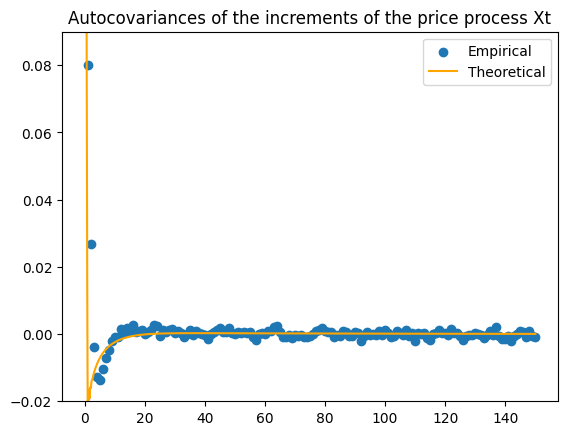

In [5]:
# Calculate empirical autocovariances of the price process increments

wd = os.getcwd()
df_Xt = pd.read_parquet(wd + "\\data\\Xt_1000000.parquet")
Xt = df_Xt.values[:].squeeze()
Xt_increments = np.diff(Xt, n=h, axis=0)
std = Xt_increments.std(ddof=0, axis=0)

nlags = 150
ccvs = [std ** 2]
for k in range(1, nlags + 1):
    ccv = calculate_cross_covariances(
        Xt_increments,
        Xt_increments,
        k=k,
        adjust_denominator=False,
    )
    ccvs.append(ccv[0])
ccvs = np.array(ccvs)

invert_vals = []
arr_tau = np.linspace(1e-3, nlags, 1000)
epochs_iter_u = tqdm(arr_tau, desc="iteration", miniters=1)
for u in epochs_iter_u:
    invert_vals.append(float(__invertLaplace__hatCN(u)))
arr_tau[0] = 0

plt.scatter(range(len(ccvs))[0:], ccvs[0:], label='Empirical')
plt.plot(arr_tau[0:], invert_vals[0:], color='orange', label='Theoretical')
plt.ylim(-0.02, 0.09)
plt.title('Autocovariances of the increments of the price process Xt')
plt.legend()

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

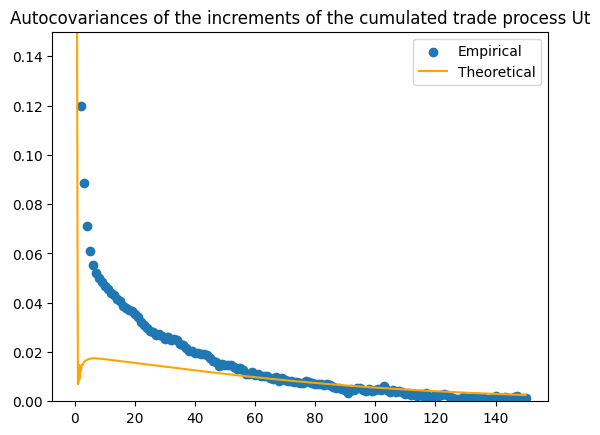

In [6]:
# Calculate empirical autocovariances of the cumulated trade process increments

wd = os.getcwd()
df_Ut = pd.read_parquet(wd + "\\data\\Ut_1000000.parquet")
Ut = df_Ut.values[:].squeeze()
Ut_increments = np.diff(Ut, n=h, axis=0)
std = Ut_increments.std(ddof=0, axis=0)

nlags = 150
ccvs = [std ** 2]
for k in range(1, nlags + 1):
    ccv = calculate_cross_covariances(
        Ut_increments,
        Ut_increments,
        k=k,
        adjust_denominator=False,
    )
    ccvs.append(ccv[0])
ccvs = np.array(ccvs)
    
invert_vals = []
arr_tau = np.linspace(1e-3, nlags, 1000)
epochs_iter_u = tqdm(arr_tau, desc="iteration", miniters=1)
for u in epochs_iter_u:
    invert_vals.append(float(__invertLaplace__hatCT(u)))
arr_tau[0] = 0

plt.scatter(range(len(ccvs))[0:], ccvs[0:], label='Empirical')
plt.plot(arr_tau[0:], invert_vals[0:], color='orange', label='Theoretical')
plt.ylim(0.0, 0.15)
plt.title('Autocovariances of the increments of the cumulated trade process Ut')
plt.legend()

# Kernel Estimation

We will calculate $\Phi_t^{ij}$ wwith an iterative way :

1) We first choose an discretization step dt for a trapezoidal quadrature.
2) We will get $\Phi_{s_m}^{ij} = g_{s_m}^{ij} - \sum_k \sum_l w_l g_{s_m -s_l}^{kl} \Phi_{s_l}^{ik}$
Since $g$ and $\Phi$ are nul for negative time, we can compute everything with the following iterative method.
We compute $\Phi_{s_1}^{ij} = g_{s_1}^{ij}$ pour $i,j = 1,...,4$
Then we compute $\Phi_{s_2}^{ij} = g_{s_2}^{ij} - \sum_k dt g_{s_2-s_1}^{kj} \Phi_{s_1}{ik}$. And so on...
We get $\Phi$ for $s_1, ..., s_m$, we can finally interpolate for avery $t$ (with a better accuracy than with the linear interpolation) with the formula $\Phi_{t}^{ij} = g_{t}^{ij} - \sum_k \sum_l w_l g_{t -s_l}^{kl} \Phi_{s_l}^{ik}$.

In [7]:
dfJT = pd.read_parquet('data/jumptimes_1000000.parquet')

In [8]:
def g_ij(s1, s2, T, dt) :
    
    e = np.zeros(int(T/dt))
    n_batch = 0
    i = 0
    i2 = 0
    batch_beginning = s2[i2]
    n_data = min(len(s1), len(s2))
    while ((i<n_data-1) and (i2<n_data - 1)) :
        while ((s1[i] <= batch_beginning) and (i<n_data-1)): #Recherche du saut de s1 suivant le saut de s2, on met un <= pour le cas s1 = s
            i+=1
        jumptime = s1[i] - batch_beginning
        if jumptime > T :
            #Recherche du batch_beginning
            while (s2[i2]<s1[i] and (i2<n_data - 1)) :
                i2+=1
            batch_beginning = s2[i2] 
            n_batch+=1
        else :
            e[int(jumptime/dt)]+=1
        i+=1
    e = e/n_batch
    Lambda = 1/s1.diff()[1:].mean()
    g = e/dt - Lambda
    return g

In [9]:
#Code des g_ij pour T = 100, dt = 0.5

T = 100 #Horizon d'estiamtion de g_t
dt = 0.5 #Pas de discrétisation de g_t
s1 = dfJT['0'].dropna()
s2 = dfJT['1'].dropna()
s3 = dfJT['2'].dropna()
s4 = dfJT['3'].dropna()
g = np.zeros((4,4,int(T/dt)))
for i in range(4) :
    for j in range(4) :
        g[i,j,:] =  g_ij(locals()[f"s{i+1}"], locals()[f"s{j+1}"], T, dt)

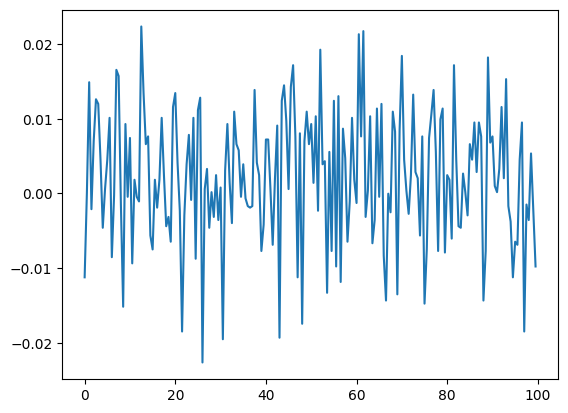

In [10]:
#Plot de g_t

x = np.arange(0,T, dt)
plt.plot(x, g[0,0,:] )
plt.show()

In [11]:
#Calcul de phi
time_steps = int(T/dt)
phi = np.copy(g) #On s'économise le premier terme de phi_t^ij = g_t^ij
for m in range(time_steps) :
    for i in range(4) :
        for j in range(4) :     
            for k in range(4) :
                for l in range(m) :
                    phi[i,j,m] -= dt*g[k,j,m-l]*phi[i,k,l]

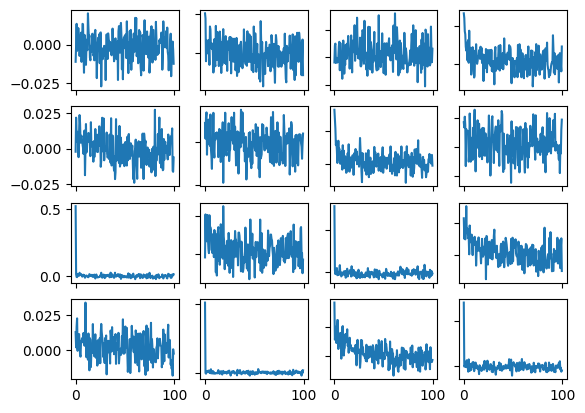

In [12]:
x = np.arange(0,T, dt)
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].plot(x, phi[i,j,:])

for ax in axs.flat:
    ax.label_outer()